In [64]:
# Import Statements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [65]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.utils import resample

In [66]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [68]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2

In [69]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix 
from sklearn.metrics import classification_report, precision_recall_curve, auc, precision_score, recall_score

## Data Wrangling

In [70]:
# read train files
transactions = pd.read_csv('/Users/shudeep/Documents/project/files/train_transaction.csv')

In [71]:
identity = pd.read_csv('/Users/shudeep/Documents/project/files/train_identity.csv')

In [128]:
df = pd.merge(transactions, identity, on='TransactionID', how='left')

In [129]:
df.dtypes.value_counts()

float64    399
object      31
int64        4
dtype: int64

In [130]:
df.shape

(590540, 434)

In [131]:
# minimum number of non-missing values that a column must have
threshold = int(590540 * 0.85)

In [132]:
df.dropna(axis = 1, thresh = threshold, inplace = True)

In [133]:
df['isFraud'].isnull().sum()

0

In [134]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

In [135]:
df.drop(columns = to_drop, inplace = True)
df.shape

(590540, 54)

In [136]:
df.select_dtypes(include=['object']).head()

,ProductCD,card4,card6
0,W,discover,credit
1,W,mastercard,credit
2,W,visa,debit
3,W,mastercard,debit
4,H,mastercard,credit


In [137]:
df.select_dtypes(include=['object']).isnull().sum()

ProductCD       0
card4        1577
card6        1571
dtype: int64

In [138]:
# Create a set of dummy variables from categorical variables
df = pd.get_dummies(df, columns=['ProductCD', 'card4','card6'], drop_first = True, dummy_na = True)
df.shape

(590540, 64)

In [139]:
df1 = df.drop('isFraud', axis = 1)

## Prepping the Test files

In [140]:
# read train files
trans = pd.read_csv('/Users/shudeep/Documents/project/files/test_transaction.csv')

In [141]:
identifier = pd.read_csv('/Users/shudeep/Documents/project/files/test_identity.csv')

In [142]:
test = pd.merge(trans, identifier, on='TransactionID', how='left')

In [143]:
test = pd.get_dummies(test, columns=['ProductCD', 'card4','card6'], drop_first = True, dummy_na = True)

In [144]:
## USING only columns that two columns share

features_train = set(df1.columns)
features_test = set(test.columns)

common_features = features_train.intersection(features_test)

In [145]:
df1 = df1[common_features]
test = test[common_features]

## Missing Data

In [146]:
df1.isnull().any(axis=1).sum()

153203

In [147]:
imputer = IterativeImputer(n_nearest_features=100)

In [148]:
imputed = imputer.fit_transform(df1)

In [149]:
df_imputed = pd.DataFrame(imputed)

# assigning back column names from original df
df_imputed.columns=df1.columns.values

In [150]:
df_imputed.head()

,ProductCD_R,card4_mastercard,V53,card2,V66,V118,V305,V12,V123,card6_nan,...,V130,ProductCD_H,V281,card3,card1,ProductCD_W,V27,V300,V117,V290
0,0.0,0.0,1.000000,332.089324,1.000000,1.0,1.0,1.000000,1.0,0.0,...,0.0,0.0,0.0,150.0,13926.0,1.0,0.000000,0.0,1.0,1.0
1,0.0,1.0,0.000000,404.000000,1.000000,1.0,1.0,0.000000,1.0,0.0,...,0.0,0.0,0.0,150.0,2755.0,1.0,0.000000,0.0,1.0,1.0
2,0.0,0.0,1.000000,490.000000,1.000000,1.0,1.0,1.000000,1.0,0.0,...,0.0,0.0,0.0,150.0,4663.0,1.0,0.000000,0.0,1.0,1.0
3,0.0,1.0,1.000000,567.000000,1.000000,1.0,1.0,1.000000,1.0,0.0,...,354.0,0.0,0.0,150.0,18132.0,1.0,0.000000,0.0,1.0,1.0
4,0.0,1.0,0.198248,514.000000,1.001631,1.0,1.0,0.040806,1.0,0.0,...,0.0,1.0,0.0,150.0,4497.0,0.0,0.004898,0.0,1.0,1.0


In [151]:
test_imputed = imputer.transform(test)

In [152]:
test_df = pd.DataFrame(test_imputed)

# assigning back column names from original df
test_df.columns=test.columns.values

In [153]:
test_df.head()

,ProductCD_R,card4_mastercard,V53,card2,V66,V118,V305,V12,V123,card6_nan,...,V130,ProductCD_H,V281,card3,card1,ProductCD_W,V27,V300,V117,V290
0,0.0,0.0,0.0,111.0,0.0,1.0,1.0,0.0,1.0,0.0,...,47.950001,0.0,0.0,150.0,10409.0,1.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,111.0,1.0,1.0,1.0,1.0,1.0,0.0,...,280.000000,0.0,0.0,150.0,4272.0,1.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,574.0,1.0,1.0,1.0,1.0,1.0,0.0,...,705.000000,0.0,0.0,150.0,4476.0,1.0,0.0,0.0,1.0,1.0
3,0.0,0.0,1.0,360.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.000000,0.0,0.0,150.0,10989.0,1.0,0.0,0.0,1.0,1.0
4,0.0,1.0,1.0,452.0,1.0,1.0,1.0,1.0,1.0,0.0,...,183.850006,0.0,0.0,150.0,18018.0,1.0,0.0,0.0,1.0,1.0


In [154]:
# split into feature and target variable

X = df_imputed
y = df['isFraud']

In [155]:
#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=77)

## Class Imbalance

In [156]:
print(y_train.value_counts())

0    455965
1     16467
Name: isFraud, dtype: int64


In [157]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X.isFraud==0]
fraud = X[X.isFraud==1]

# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
print(downsampled.isFraud.value_counts())

1    16467
0    16467
Name: isFraud, dtype: int64


In [158]:
y_train = downsampled.isFraud
X_train = downsampled.drop('isFraud', axis=1)

## Feature Selection

In [159]:
# feature extraction
k_best = SelectKBest(score_func=f_classif, k=40)
# fit on train set
X_train_reduced = k_best.fit_transform(X_train, y_train)
X_test_reduced = k_best.transform(X_test)


/Users/shudeep/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [24] are constant.
  UserWarning)
/Users/shudeep/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [160]:
X_holdout_reduced = k_best.transform(test_df)

In [161]:
# Get columns to keep
names = X_train.columns.values[k_best.get_support()]
print(names)

['V53' 'V66' 'V118' 'V305' 'V12' 'V123' 'card6_credit' 'TransactionID'
 'V124' 'V282' 'C5' 'V109' 'card6_debit' 'V313' 'D1' 'V111' 'V55' 'V129'
 'V19' 'card5' 'V115' 'addr2' 'V29' 'addr1' 'V288' 'V23' 'V61' 'V108'
 'card4_discover' 'V98' 'C1' 'V56' 'D10' 'ProductCD_H' 'V281' 'card3'
 'ProductCD_W' 'V300' 'V117' 'V290']


## MODELS


In [162]:
# Instantiate
rf = RandomForestClassifier(n_estimators=500, random_state = 777, n_jobs= -1)  

# Fit to features
rf_model = rf.fit(X_train_reduced, y_train) 

# Predict the labels of the test set: y_pred
y_pred_rf = rf_model.predict(X_test_reduced)

# Use score method to get accuracy of model
score_rf = rf_model.score(X_test_reduced, y_test)

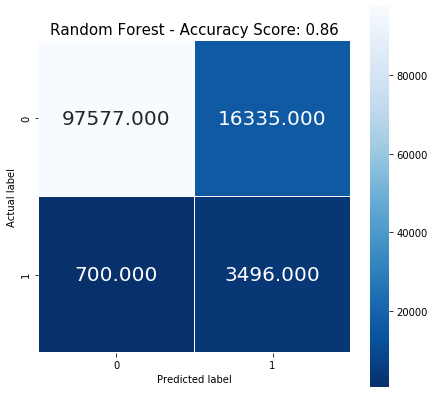

In [163]:
# Compute and visualize confusion matrix 
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(7,7))
sns.heatmap(cm_rf, annot=True,  annot_kws={"size": 20}, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Random Forest - Accuracy Score: {:.2f}'.format(score_rf)

plt.title(all_sample_title, size = 15)
plt.show()

In [164]:
# Instantiate Adaboost
ada = AdaBoostClassifier(n_estimators= 500, random_state=0)

# Fit to feature
ada.fit(X_train_reduced, y_train) 

# Predict the labels of the test set: y_pred
y_pred_ada = ada.predict(X_test_reduced)

# Use score method to get accuracy of model
score_ada = ada.score(X_test_reduced, y_test)

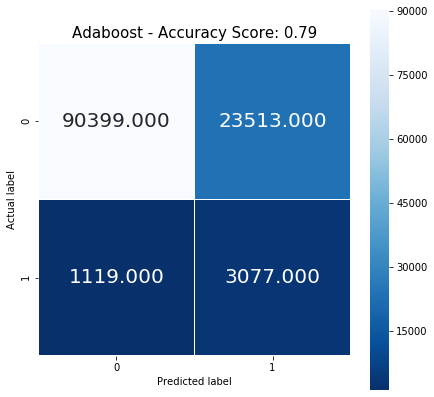

In [165]:
# Compute and visualize confusion matrix 
cm_ada = confusion_matrix(y_test, y_pred_ada)

plt.figure(figsize=(7,7))
sns.heatmap(cm_ada, annot=True,  annot_kws={"size": 20}, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Adaboost - Accuracy Score: {:.2f}'.format(score_ada)

plt.title(all_sample_title, size = 15)
plt.show()

In [166]:
grd = GradientBoostingClassifier(n_estimators=500)

# Fit to feature
grd.fit(X_train_reduced, y_train) 

# Predict the labels of the test set: y_pred
y_pred_grd = grd.predict(X_test_reduced)

# Use score method to get accuracy of model
score_grd = grd.score(X_test_reduced, y_test)

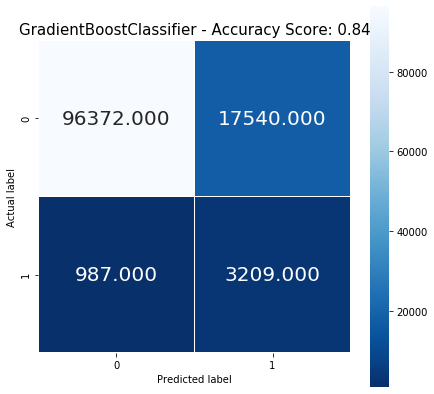

In [167]:
# Compute and visualize confusion matrix 
cm_grd = confusion_matrix(y_test, y_pred_grd)

plt.figure(figsize=(7,7))
sns.heatmap(cm_grd, annot=True,  annot_kws={"size": 20}, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'GradientBoostClassifier - Accuracy Score: {:.2f}'.format(score_grd)

plt.title(all_sample_title, size = 15)
plt.show()

## XGBOOST

In [168]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [169]:
#Train the XGboost Model for Classification

model1 = xgb.XGBClassifier()
model2 = xgb.XGBClassifier(n_estimators=500, max_depth=8, learning_rate=0.1, subsample=0.5)

train_model1 = model1.fit(X_train_reduced, y_train)
train_model2 = model2.fit(X_train_reduced, y_train)

In [171]:
pred1 = model1.predict(X_test_reduced)
pred2 = model2.predict(X_test_reduced)

In [172]:
print("Accuracy for model 1: %.2f" % (accuracy_score(y_test, pred1) * 100))
print("Accuracy for model 2: %.2f" % (accuracy_score(y_test, pred2) * 100))

Accuracy for model 1: 82.63
Accuracy for model 2: 85.68


In [179]:
param_test = {
 'max_depth':[6,8,10],
 'min_child_weight':[4,5,6]
}

gsearch = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate=0.1, n_estimators=300, gamma=0, subsample=0.5, 
                                                     colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, 
                                                     scale_pos_weight=1,seed=27), param_grid = param_test, 
                                                     scoring='roc_auc',n_jobs=4,iid=False, cv=5)

train_model4 = gsearch.fit(X_train_reduced, y_train)
pred4 = train_model4.predict(X_test_reduced)

print("Accuracy for model 4: %.2f" % (accuracy_score(y_test, pred4) * 100))

Accuracy for model 4: 86.14


In [180]:
print("AUC score model 4: %.2f" % (roc_auc_score(y_test, pred4)))

AUC score model 4: 0.84


## Write to CSV for submission

In [174]:
# Predict the labels of the test set: y_pred
#y_pred_holdout = grd.predict(X_holdout_reduced)


In [175]:
#submission = pd.DataFrame({ 'TransactionId': test.TransactionID.values, 'isFraud': y_pred_holdout })
#submission.to_csv("submission.csv", index=False)

In [176]:
#check = pd.read_csv('/Users/shudeep/Documents/project/submission.csv')

In [177]:
#check.head()

In [178]:
#check.shape